In [67]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images = 25, size = (1,28,28)):
  image_unflat = image_tensor.detach().cpu().view(-1,*size)
  image_grid = make_grid(image_unflat[:num_images], nrow = 5)
  plt.imshow(image_grid.permute(1,2,0).squeeze())
  plt.show()

In [50]:
def get_generator_block(input_dim,output_dim):
  return nn.Sequential(
      nn.Linear(input_dim,output_dim),
      nn.BatchNorm1d(output_dim),
      nn.ReLU(inplace = True)
  )

In [51]:
def test_gen_block(in_features, out_features, num_tests = 1000):
  block = get_generator_block(in_features, out_features)

  assert len(block) == 3
  assert type(block[0]) == nn.Linear
  assert type(block[1]) == nn.BatchNorm1d
  assert type(block[2]) == nn.ReLU

  test_input = torch.randn(num_tests , in_features)
  test_output = block(test_input)
  assert tuple(test_output.shape) == (num_tests , out_features)
  assert test_output.std() > 0.55
  assert test_output.std() < 0.65

test_gen_block(25,12)
test_gen_block(15,28)
print("success")


success


In [52]:
class Generator(nn.Module):
  def __init__(self, z_dim = 10,im_dim = 784,hidden_dim = 128):
    super(Generator , self).__init__()
    self.gen = nn.Sequential(
        get_generator_block(z_dim,hidden_dim),
        get_generator_block(hidden_dim , hidden_dim*2),
        get_generator_block(hidden_dim*2 , hidden_dim*4),
        get_generator_block(hidden_dim*4 , hidden_dim*8),
        nn.Linear(hidden_dim *8 , im_dim),
        nn.Sigmoid()
    )

  def forward(self , noise):
      return self.gen(noise)

  def get_gen(self):

      return self.gen

In [53]:
def test_generator(z_dim , im_dim, hidden_dim,num_tests = 10000):
  gen = Generator(z_dim , im_dim, hidden_dim).get_gen()

  assert len(gen) == 6
  # assert type(gen[4]) == nn.Linear
  # assert type(gen[5]) == nn.Sequential
  assert str(gen.__getitem__(4)).replace(' ', '') == f'Linear(in_features={hidden_dim * 8},out_features={im_dim},bias=True)'
  assert str(gen.__getitem__(5)).replace(' ', '') == 'Sigmoid()'

  test_input = torch.randn(num_tests , z_dim)
  test_output = gen(test_input)

  assert tuple(test_output.shape) == (num_tests , im_dim)
  assert test_output.max() <1
  assert test_output.max() >0
  assert test_output.std() >0.05
  assert test_output.std() <0.15

test_generator(5, 10, 20)
test_generator(20, 8, 24)
print("Success")

Success


In [54]:
def get_noise(n_samples, z_dims, device = 'cpu'):
  return torch.randn(n_samples , z_dims, device = device)

In [55]:
def test_get_noise(n_sample , z_dims ,device = 'cpu'):
  noise = get_noise(n_sample , z_dims ,device)

  assert tuple(noise.shape) == (n_sample , z_dims)
  assert torch.abs(noise.std() - torch.tensor(1.0)) <0.01
  assert str(noise.device).startswith(device)
test_get_noise(100,100,'cpu')
if torch.cuda.is_available():
  test_get_noise(1000,32,'cuda')
print('Success')

Success


In [56]:
def get_discriminator_block(input_dim,output_dim):
  return nn.Sequential(
      nn.Linear(input_dim,output_dim),
      nn.LeakyReLU(0.2,inplace = True)
  )


In [57]:
def test_disc_block(input_dim,output_dim,num_tests = 10000):
  block = get_discriminator_block(input_dim,output_dim)
  assert len(block) == 2
  assert type(block[0]) == nn.Linear
  assert type(block[1]) == nn.LeakyReLU
  test_input = torch.randn(num_tests , input_dim)
  test_output = block(test_input)

  assert tuple(test_output.shape) == (num_tests , output_dim)
  assert -test_output.min() / test_output.max() >0.1
  assert -test_output.min() / test_output.max() <0.3
  assert test_output.std() <0.5
  assert test_output.std() >0.3
test_disc_block(10,20,1000)
print("Success")

Success


In [58]:
class Discriminator(nn.Module):
  def __init__(self , im_dim = 784 , hidden_dim = 128):
    super(Discriminator , self).__init__()
    self.disc = nn.Sequential(
        get_discriminator_block(im_dim,hidden_dim *4),
        get_discriminator_block(hidden_dim *4 ,hidden_dim *2),
        get_discriminator_block(hidden_dim *2 ,hidden_dim),
        nn.Linear(hidden_dim,1)
    )

  def forward(self,image):
    return self.disc(image)

  def get_disc(self):
    return self.disc

In [59]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
lr = 0.00001
batch_size = 128
device = 'cpu'
dataloader = DataLoader(
    MNIST('.',download = False, transform = transforms.ToTensor()),
    batch_size = batch_size,
    shuffle = True
)

In [60]:
pip install torch

In [61]:
gen = Generator(z_dim)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr)
disc = Discriminator()
disc_opt = torch.optim.Adam(disc.parameters(),lr = lr)

In [62]:
def get_disc_loss(gen, disc, criterion, real, z_dim, device, num_images):
  fake_noise = get_noise(num_images, z_dim)
  fake = gen(fake_noise)
  disc_fake_pred = disc(fake.detach())
  disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
  disc_real_pred = disc(real)
  disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
  disc_loss = (disc_real_loss + disc_fake_loss)/2
  return disc_loss

In [63]:
def test_disc_reasonable(num_images=10):
  z_dim = 64
  gen = torch.zeros_like
  disc = nn.Identity()
  criterion = torch.mul # Multiply
  real = torch.ones(num_images, 1)
  disc_loss = get_disc_loss(gen, disc, criterion, real, z_dim,'cpu', num_images )
  assert tuple(disc_loss.shape) == (num_images, z_dim)
  assert torch.all(torch.abs(disc_loss - 0.5) < 1e-5)

  gen = torch.ones_like
  disc = nn.Identity()
  criterion = torch.mul # Multiply
  real = torch.zeros(num_images, 1)
  assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, z_dim,'cpu', num_images )) < 1e-5)

def test_disc_loss(max_tests = 10):
  z_dim = 64
  gen = Generator(z_dim)
  gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
  disc = Discriminator()
  disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
  num_steps = 0
  for real, _ in dataloader:
    cur_batch_size = len(real)
    real = real.view(cur_batch_size, -1)

  ### Update discriminator ###
    # Zero out the gradient before backpropagation
    disc_opt.zero_grad()

     # Calculate discriminator loss
    disc_loss = get_disc_loss(gen, disc, criterion, real,z_dim, device,cur_batch_size)
    assert (disc_loss - 0.68).abs() < 0.05

    # Update gradients
    disc_loss.backward(retain_graph=True)

     # Check that they detached correctly
    assert gen.gen[0][0].weight.grad is None

    # Update optimizer
    old_weight = disc.disc[0][0].weight.data.clone()
    disc_opt.step()
    new_weight = disc.disc[0][0].weight.data

        # Check that some discriminator weights changed
    assert not torch.all(torch.eq(old_weight, new_weight))
    num_steps += 1
    if num_steps >= max_tests:
      break

test_disc_reasonable()
test_disc_loss()
print("Success!")

Success!


In [64]:
def get_gen_loss(gen,disc,criterion,num_images,z_dim,device):
  fake_noise = get_noise(num_images, z_dim)
  fake = gen(fake_noise)
  disc_fake_pred = disc(fake)
  gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
  return gen_loss

In [65]:

def test_gen_reasonable(num_images=10):
  z_dim = 64
  gen = torch.zeros_like
  disc = nn.Identity()
  criterion = torch.mul # Multiply
  gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
  assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
  #Verify shape. Related to gen_noise parametrization
  assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

  gen = torch.ones_like
  disc = nn.Identity()
  criterion = torch.mul # Multiply
  real = torch.zeros(num_images, 1)
  gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
  assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
  #Verify shape. Related to gen_noise parametrization
  assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)


def test_gen_loss(num_images):
  z_dim = 64
  gen = Generator(z_dim)
  gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
  disc = Discriminator()
  disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

  gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_dim, device)

    # Check that the loss is reasonable
  assert (gen_loss - 0.7).abs() < 0.1
  gen_loss.backward()
  old_weight = gen.gen[0][0].weight.clone()
  gen_opt.step()
  new_weight = gen.gen[0][0].weight
  assert not torch.all(torch.eq(old_weight, new_weight))

test_gen_reasonable(10)
test_gen_loss(18)
print("Success!")

Success!


  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 2.9209559316635145, discriminator loss: 0.1798648121356965


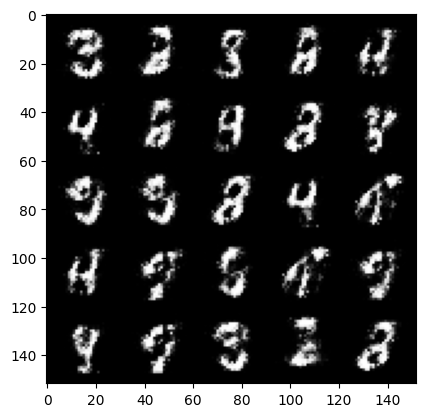

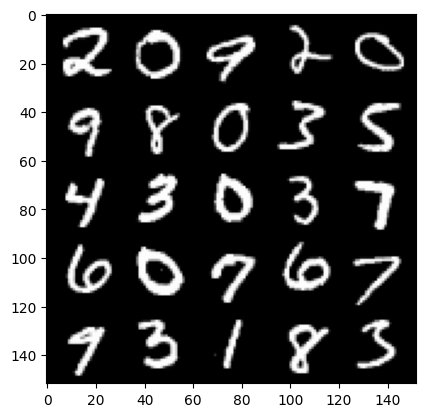

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23500: Generator loss: 3.026539027214052, discriminator loss: 0.17067236956954013


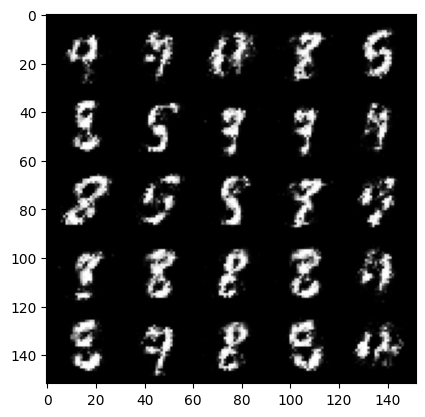

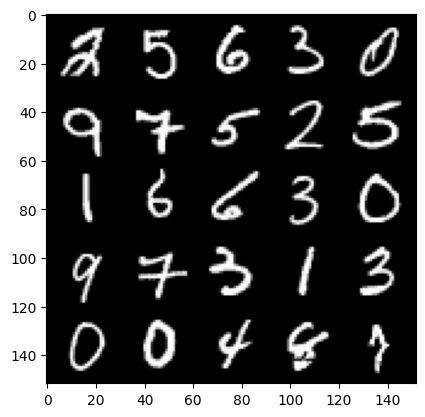

  0%|          | 0/469 [00:00<?, ?it/s]

Step 24000: Generator loss: 3.092691465854644, discriminator loss: 0.18161106298863894


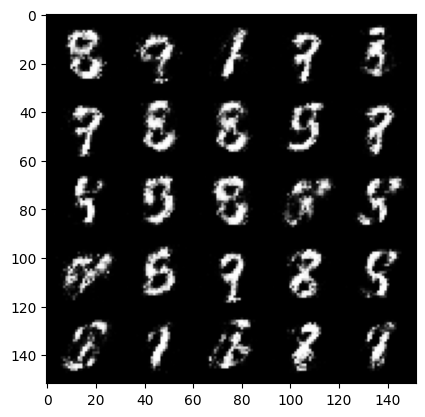

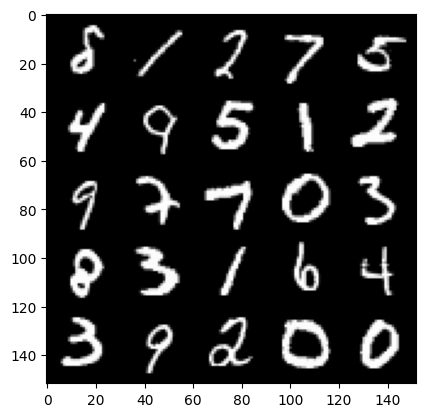

  0%|          | 0/469 [00:00<?, ?it/s]

Step 24500: Generator loss: 2.889091094970705, discriminator loss: 0.19621603426337247


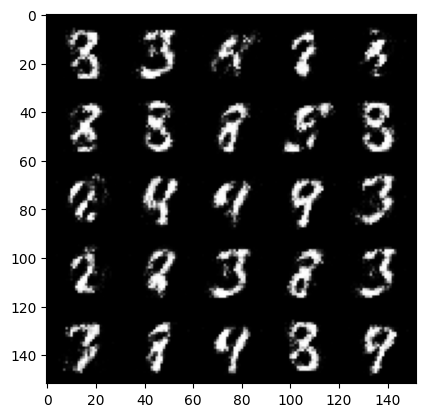

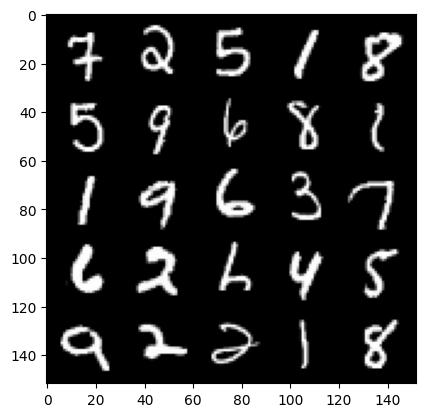

  0%|          | 0/469 [00:00<?, ?it/s]

Step 25000: Generator loss: 2.82180481481552, discriminator loss: 0.21094169056415582


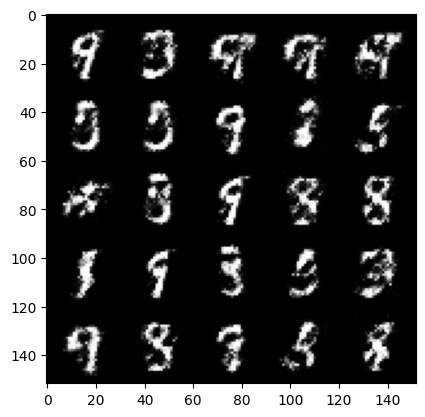

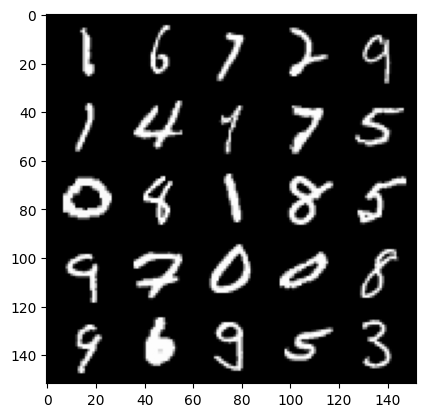

  0%|          | 0/469 [00:00<?, ?it/s]

Step 25500: Generator loss: 2.7697995033264173, discriminator loss: 0.2131778466701507


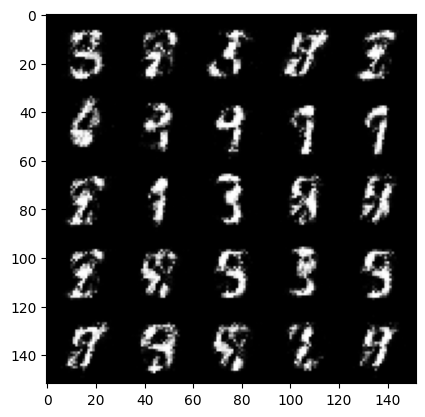

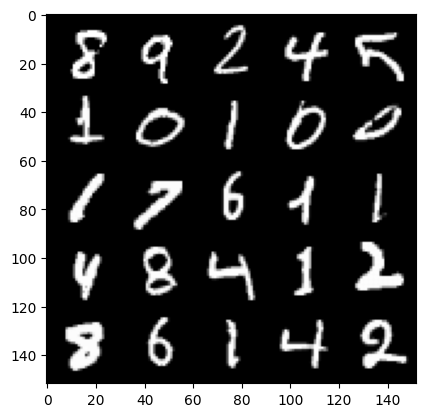

  0%|          | 0/469 [00:00<?, ?it/s]

Step 26000: Generator loss: 2.7957779526710484, discriminator loss: 0.20445722119510157


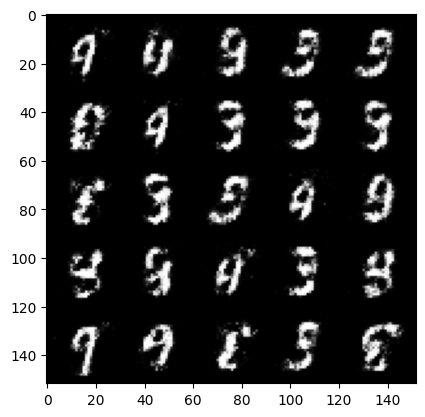

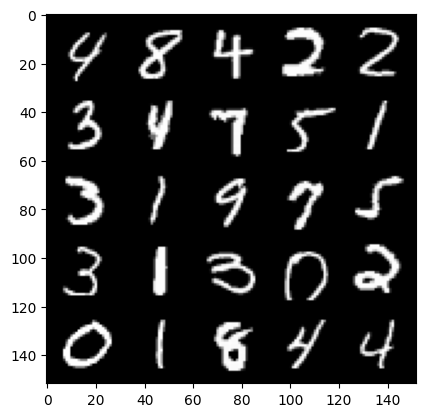

  0%|          | 0/469 [00:00<?, ?it/s]

Step 26500: Generator loss: 2.766345138549806, discriminator loss: 0.20207954323291769


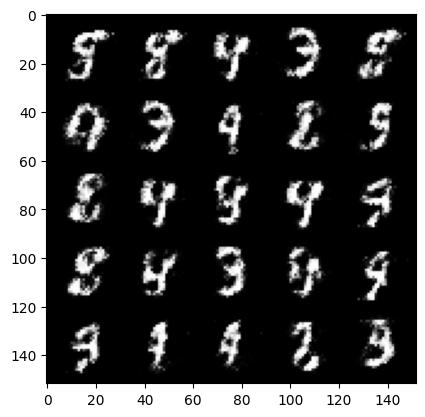

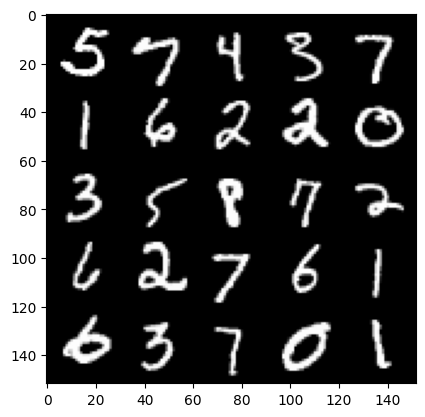

  0%|          | 0/469 [00:00<?, ?it/s]

Step 27000: Generator loss: 2.7987891464233385, discriminator loss: 0.2037747383713724


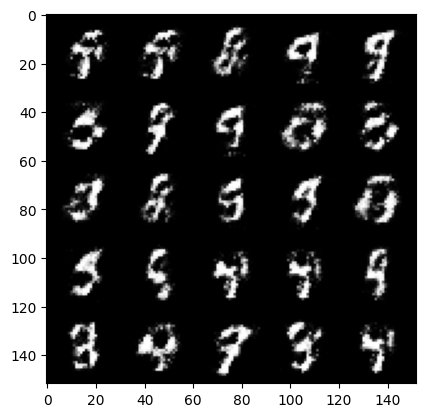

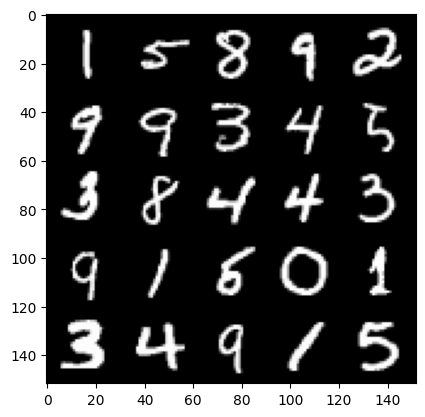

  0%|          | 0/469 [00:00<?, ?it/s]

Step 27500: Generator loss: 2.8267232918739333, discriminator loss: 0.19912423019111158


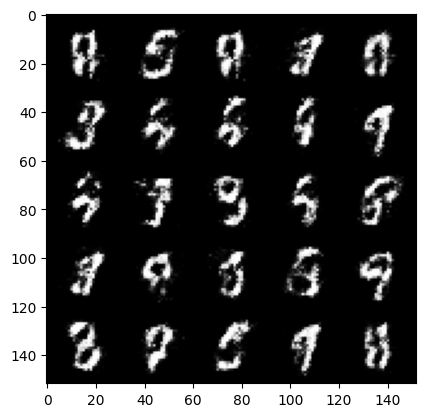

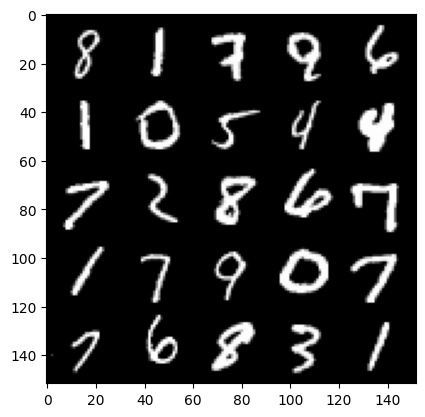

  0%|          | 0/469 [00:00<?, ?it/s]

Step 28000: Generator loss: 2.8284513583183273, discriminator loss: 0.2000605276226997


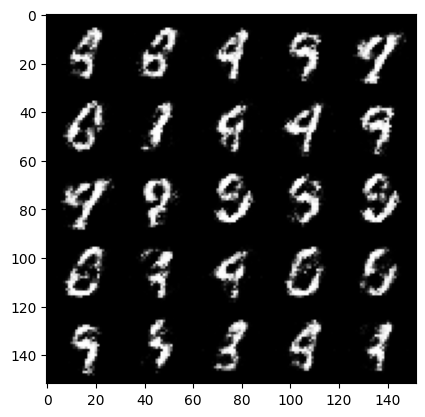

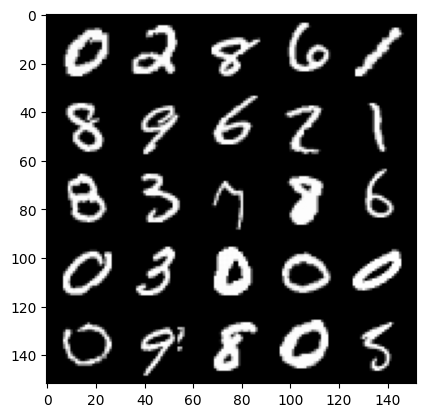

  0%|          | 0/469 [00:00<?, ?it/s]

Step 28500: Generator loss: 2.627787314414979, discriminator loss: 0.2360665477812291


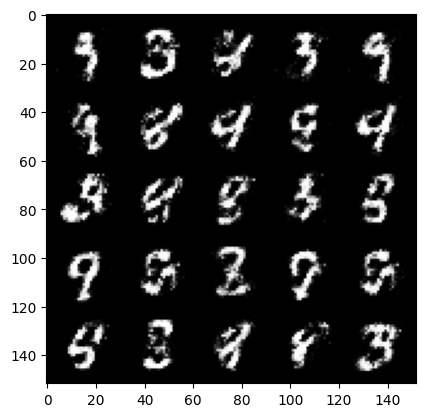

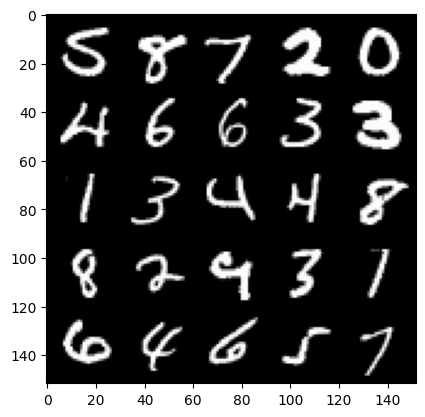

  0%|          | 0/469 [00:00<?, ?it/s]

Step 29000: Generator loss: 2.6528746066093425, discriminator loss: 0.2098934579789639


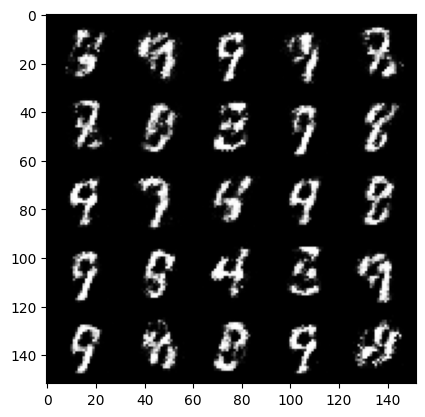

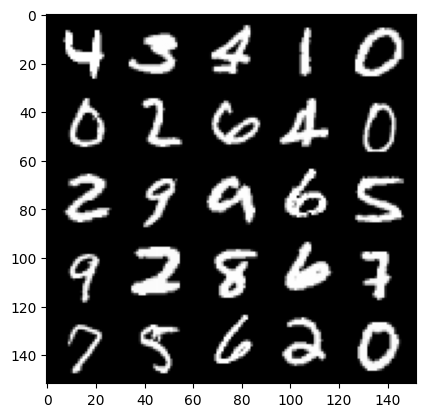

  0%|          | 0/469 [00:00<?, ?it/s]

Step 29500: Generator loss: 2.7658934950828566, discriminator loss: 0.20302740706503405


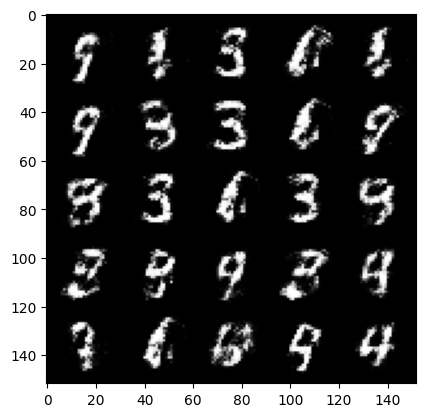

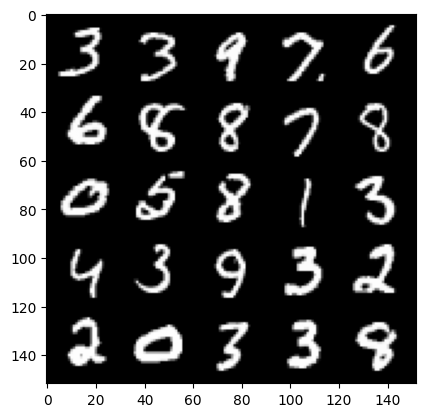

  0%|          | 0/469 [00:00<?, ?it/s]

Step 30000: Generator loss: 2.59787825345993, discriminator loss: 0.22700601741671556


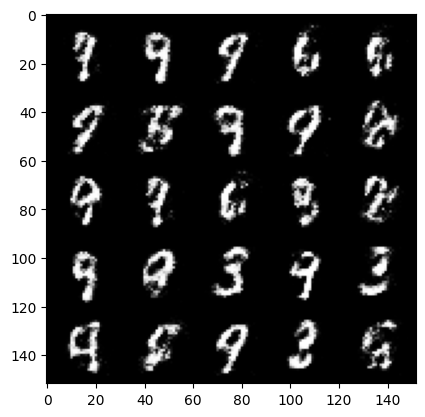

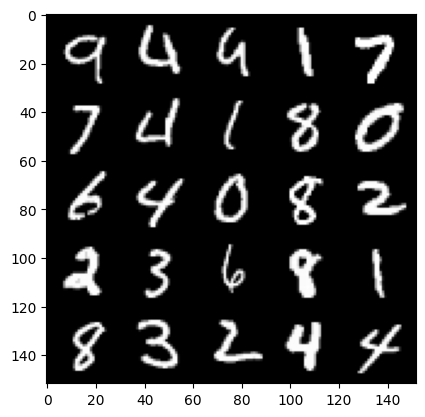

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 30500: Generator loss: 2.6009782080650328, discriminator loss: 0.23127457866072654


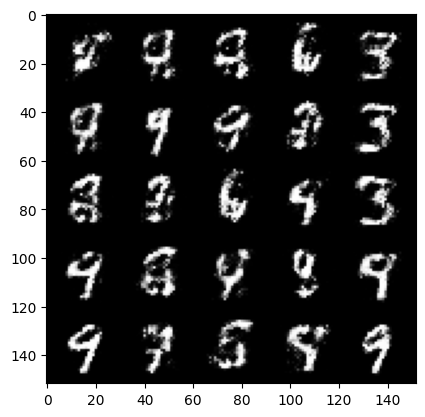

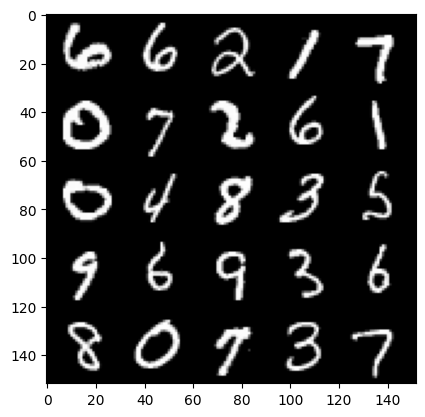

  0%|          | 0/469 [00:00<?, ?it/s]

Step 31000: Generator loss: 2.5828926043510427, discriminator loss: 0.23682740560173984


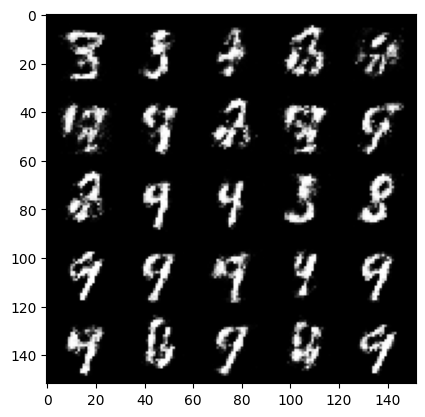

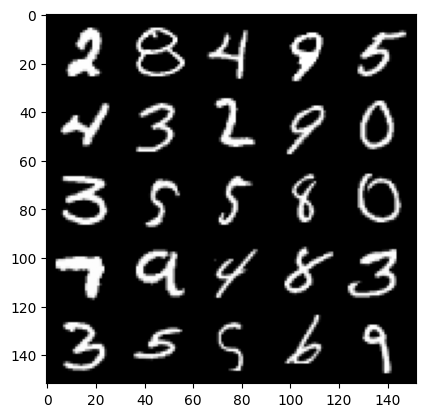

  0%|          | 0/469 [00:00<?, ?it/s]

Step 31500: Generator loss: 2.516553442955017, discriminator loss: 0.24273840114474307


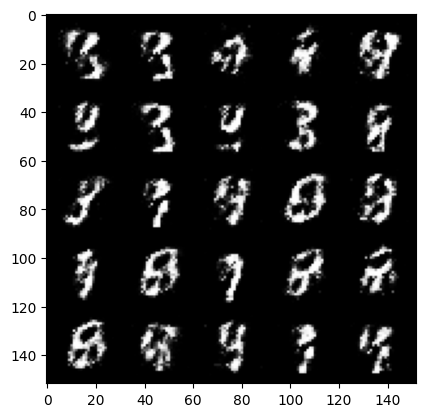

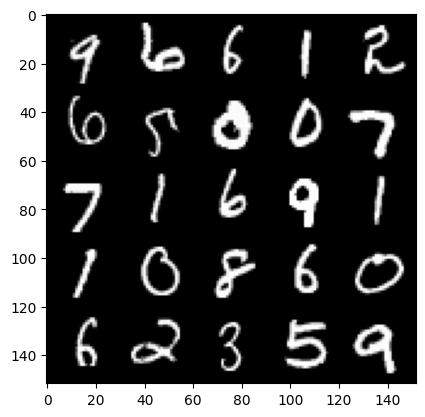

  0%|          | 0/469 [00:00<?, ?it/s]

Step 32000: Generator loss: 2.4132907018661514, discriminator loss: 0.26692367956042273


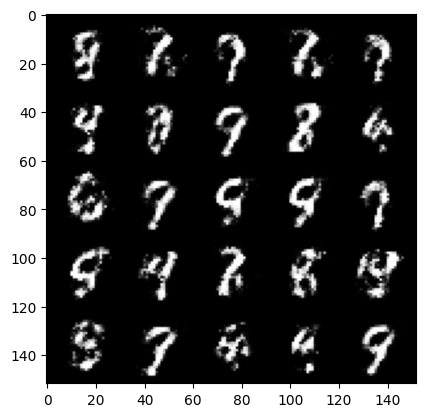

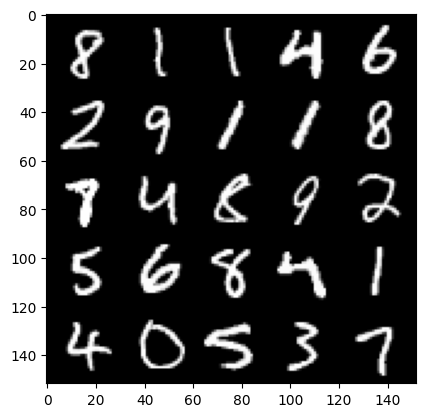

  0%|          | 0/469 [00:00<?, ?it/s]

Step 32500: Generator loss: 2.3198035206794723, discriminator loss: 0.26912974581122406


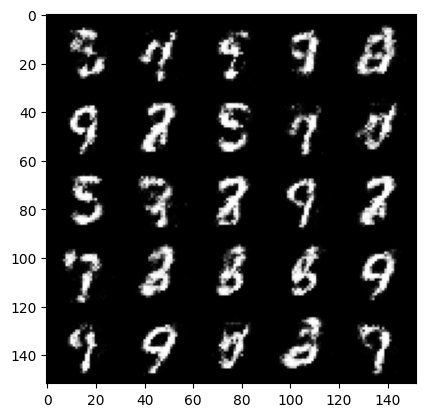

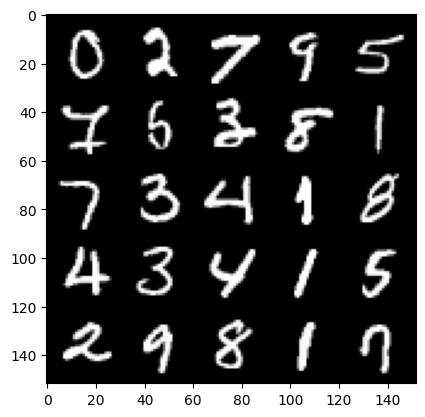

  0%|          | 0/469 [00:00<?, ?it/s]

Step 33000: Generator loss: 2.372159716367721, discriminator loss: 0.2696421646475792


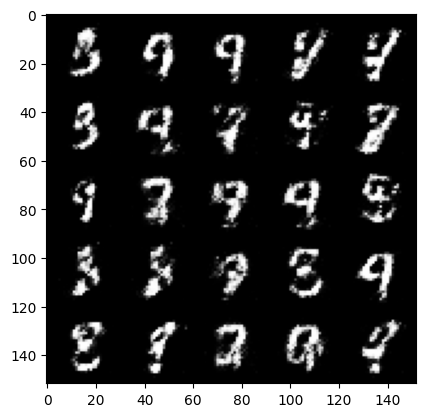

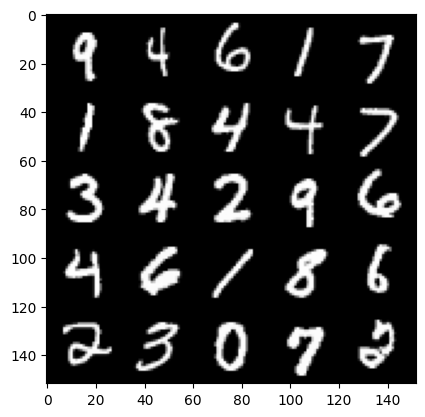

  0%|          | 0/469 [00:00<?, ?it/s]

Step 33500: Generator loss: 2.416122708797457, discriminator loss: 0.25412392759323127


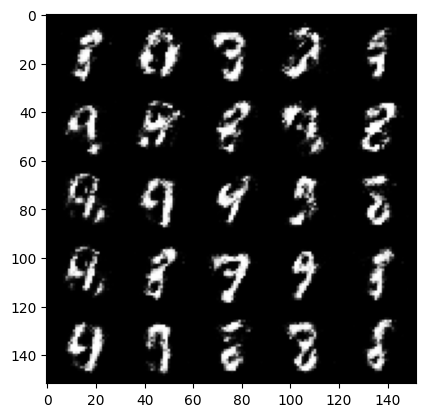

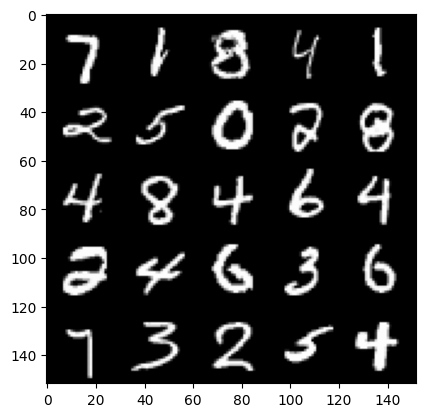

  0%|          | 0/469 [00:00<?, ?it/s]

Step 34000: Generator loss: 2.3009326112270343, discriminator loss: 0.27467304620146776


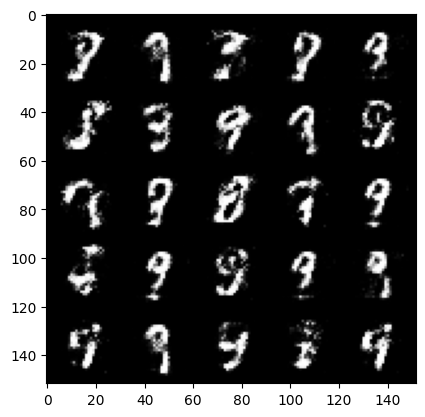

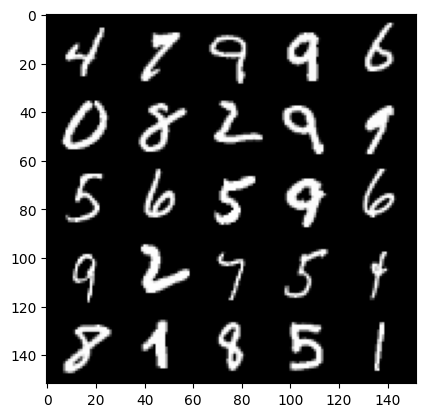

  0%|          | 0/469 [00:00<?, ?it/s]

Step 34500: Generator loss: 2.3230197124481187, discriminator loss: 0.2840893490314484


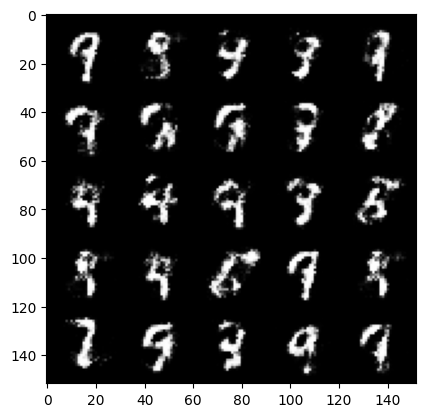

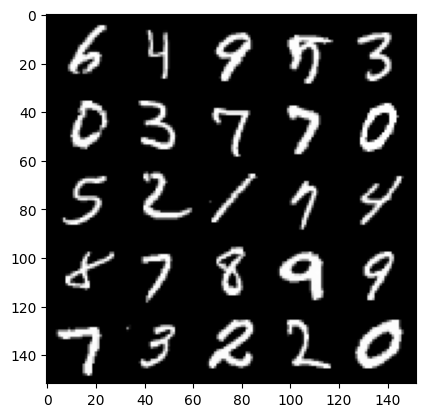

  0%|          | 0/469 [00:00<?, ?it/s]

Step 35000: Generator loss: 2.3099497692584983, discriminator loss: 0.27237592449784265


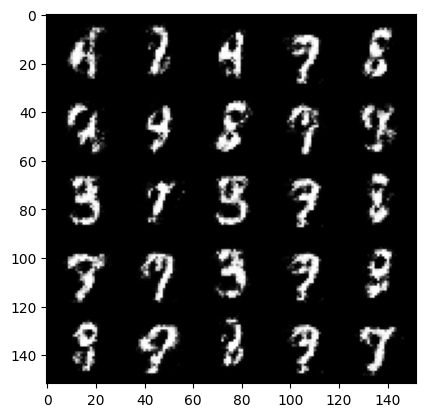

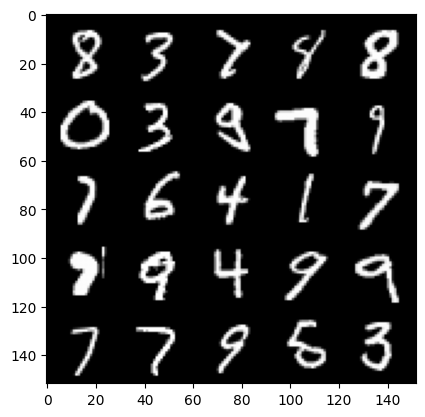

  0%|          | 0/469 [00:00<?, ?it/s]

Step 35500: Generator loss: 2.2559071009159064, discriminator loss: 0.28920677885413176


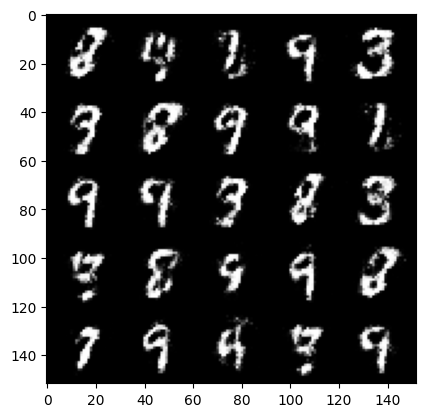

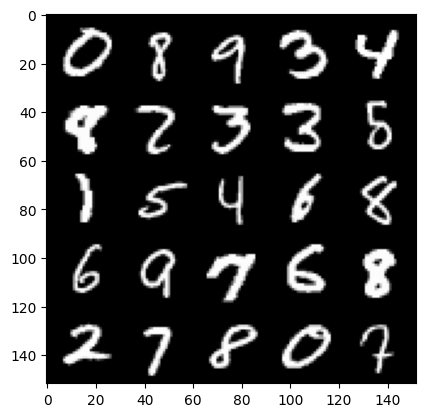

  0%|          | 0/469 [00:00<?, ?it/s]

Step 36000: Generator loss: 2.1369004859924305, discriminator loss: 0.29671692904829977


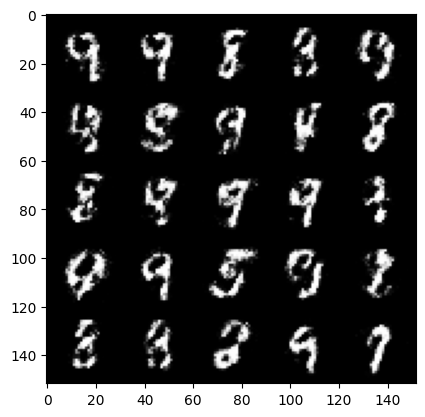

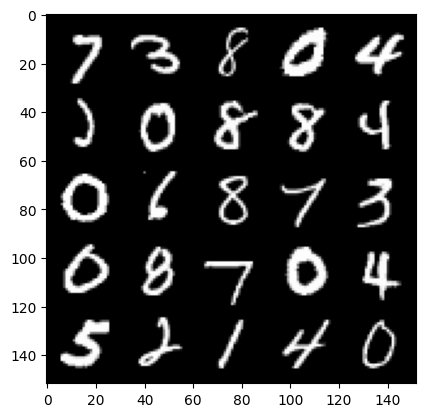

  0%|          | 0/469 [00:00<?, ?it/s]

Step 36500: Generator loss: 2.147716522216797, discriminator loss: 0.2948739410340786


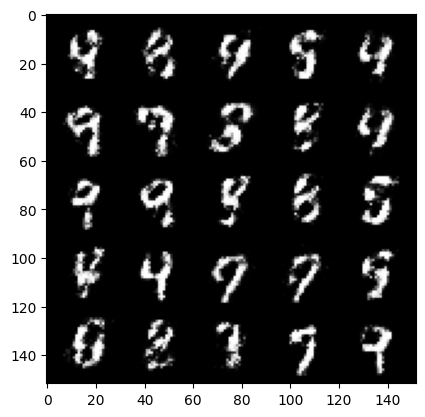

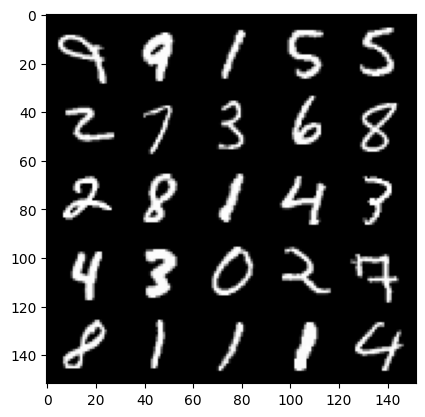

  0%|          | 0/469 [00:00<?, ?it/s]

Step 37000: Generator loss: 2.1787485029697407, discriminator loss: 0.2852800972163678


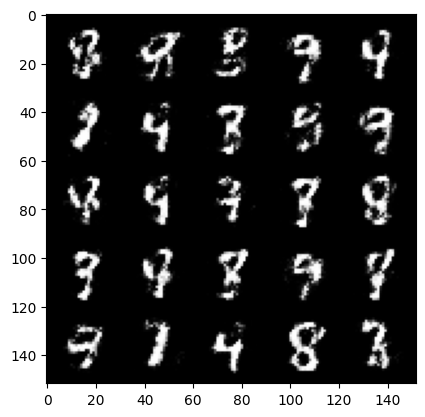

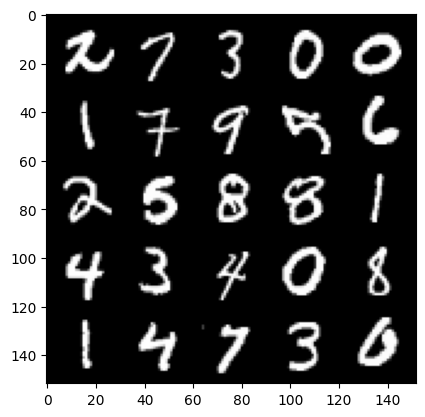

  0%|          | 0/469 [00:00<?, ?it/s]

Step 37500: Generator loss: 2.1308985843658443, discriminator loss: 0.30235006746649745


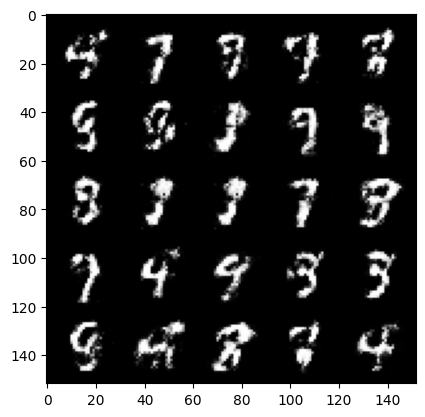

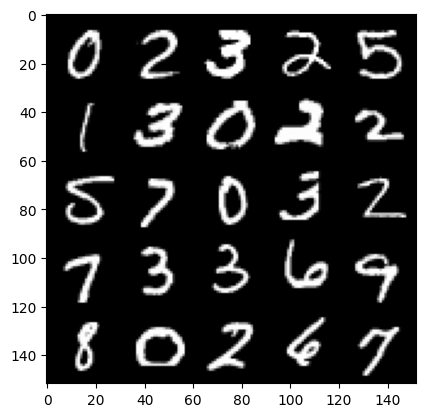

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 38000: Generator loss: 2.202404521226885, discriminator loss: 0.2923931954503059


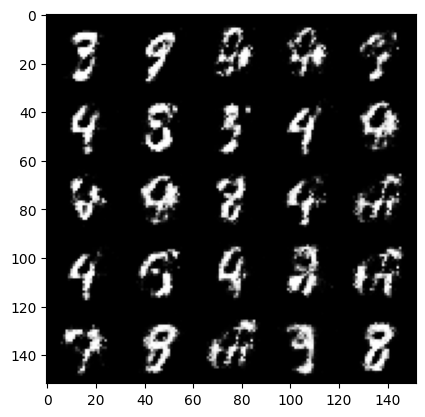

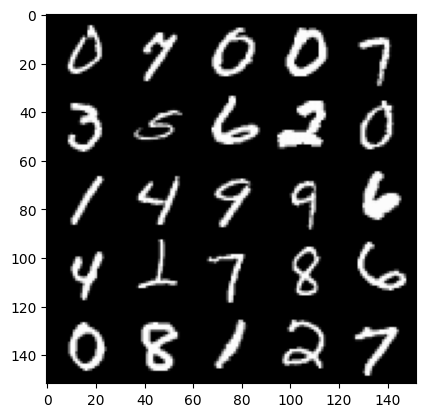

  0%|          | 0/469 [00:00<?, ?it/s]

Step 38500: Generator loss: 2.103153037309646, discriminator loss: 0.3146519929766659


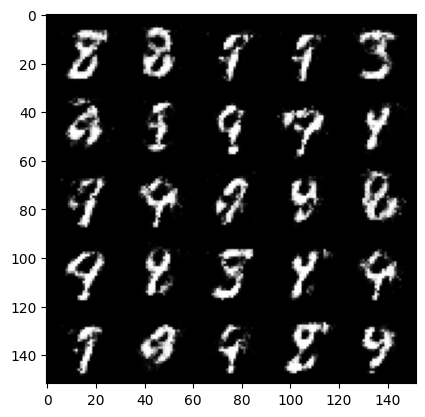

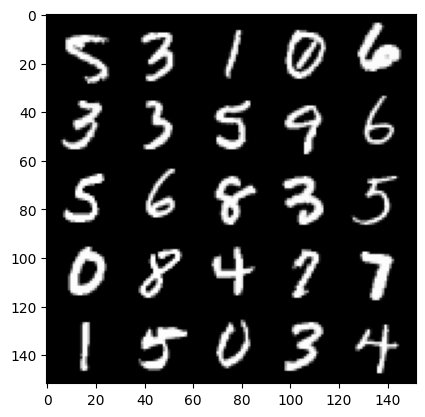

  0%|          | 0/469 [00:00<?, ?it/s]

Step 39000: Generator loss: 2.1210925691127787, discriminator loss: 0.29149433931708335


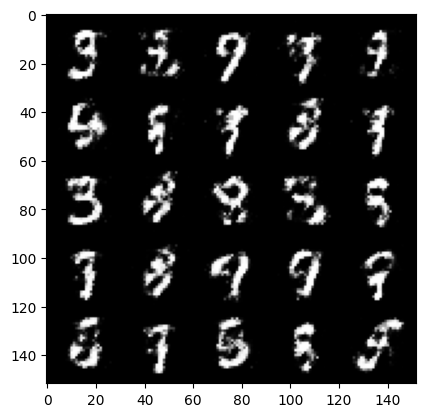

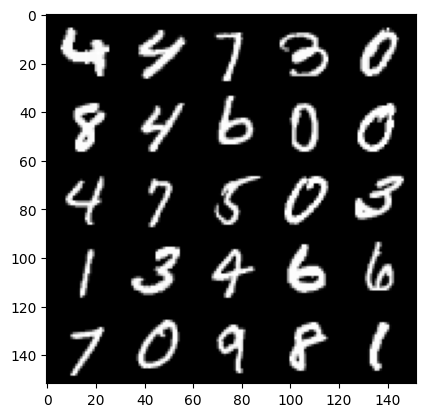

  0%|          | 0/469 [00:00<?, ?it/s]

Step 39500: Generator loss: 2.003239299297333, discriminator loss: 0.323969582378864


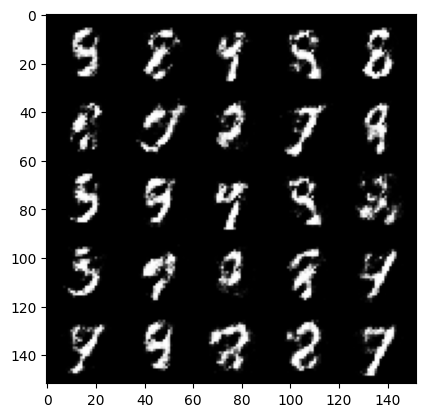

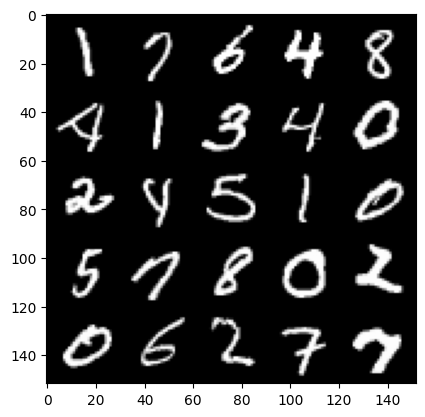

  0%|          | 0/469 [00:00<?, ?it/s]

Step 40000: Generator loss: 2.0448183009624494, discriminator loss: 0.312786297053099


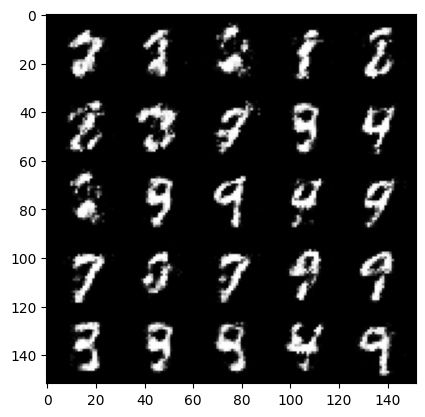

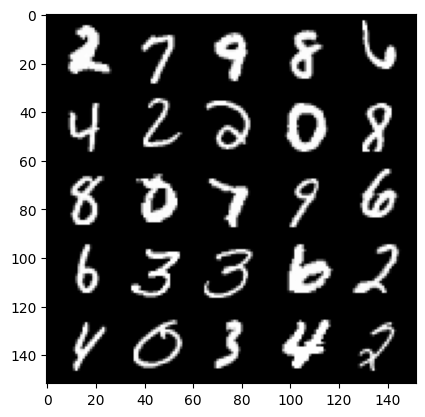

  0%|          | 0/469 [00:00<?, ?it/s]

Step 40500: Generator loss: 2.1416133944988256, discriminator loss: 0.2861664117872714


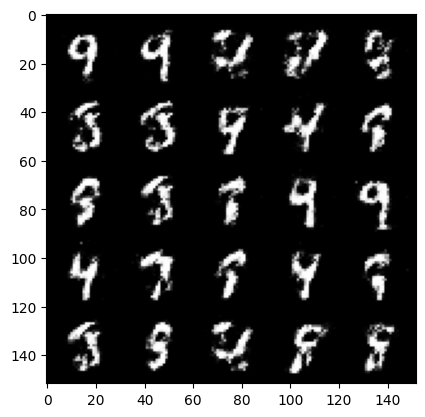

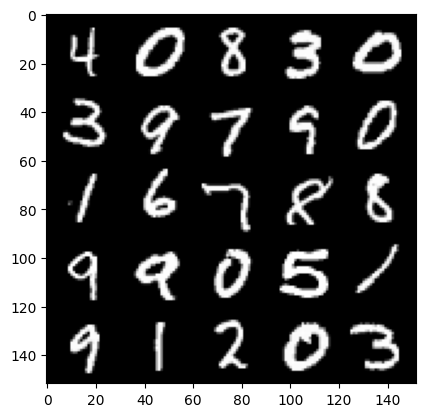

  0%|          | 0/469 [00:00<?, ?it/s]

Step 41000: Generator loss: 2.0367103896141066, discriminator loss: 0.32058316218852984


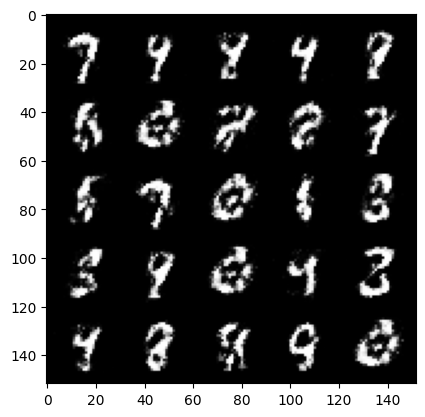

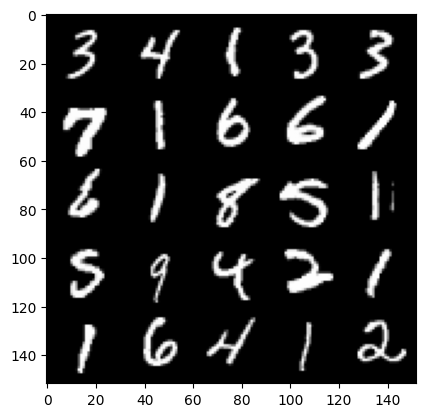

  0%|          | 0/469 [00:00<?, ?it/s]

Step 41500: Generator loss: 2.100111371755599, discriminator loss: 0.29248238000273713


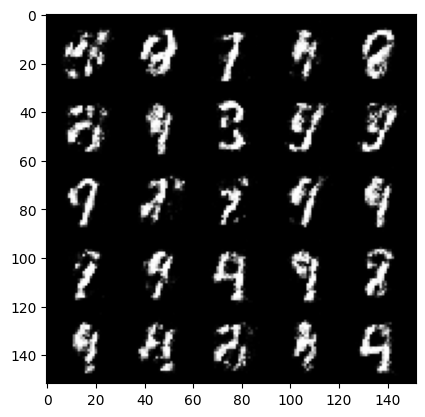

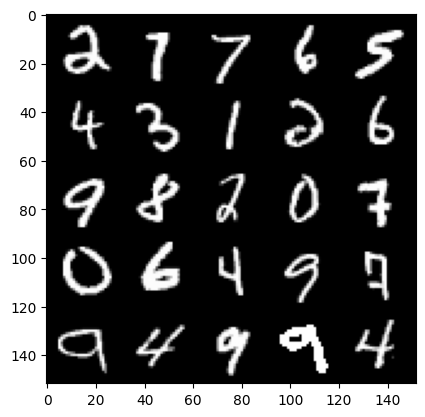

KeyboardInterrupt: 

In [68]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False

for epoch in range(n_epochs):
  for real,_ in tqdm(dataloader):
    cur_batch_size = len(real)
    real = real.view(cur_batch_size, -1)

    disc_opt.zero_grad()
    disc_loss = get_disc_loss(gen, disc, criterion, real, z_dim, 'cpu',cur_batch_size)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    gen_opt.zero_grad()
    gen_loss = get_gen_loss(gen, disc, criterion,cur_batch_size, z_dim, 'cpu')
    gen_loss.backward()
    gen_opt.step()

    mean_discriminator_loss+=disc_loss.item()/display_step
    mean_generator_loss+=gen_loss.item()/display_step

    if cur_step % display_step == 0 and cur_step > 0:
      print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
      fake_noise = get_noise(cur_batch_size, z_dim,'cpu')
      fake = gen(fake_noise)
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0
    cur_step += 1